
# ROOT RDataFrame
Documentaion: https://root.cern/doc/master/classROOT_1_1RDataFrame.html 
- ROOT's high level analysis interface available in ROOT v6.14+ 
- Analysis is defined as a sequence of operations to be performed on the data frame object 
- Much faster than TTree::Draw(), TTREE::GetEntry() or TTree::READER 
    - Multihreading
    - Parallel actions per event loop
    - Optimised filtering and I/O
- Provides various methods to perform most common operations required by ROOT analysis

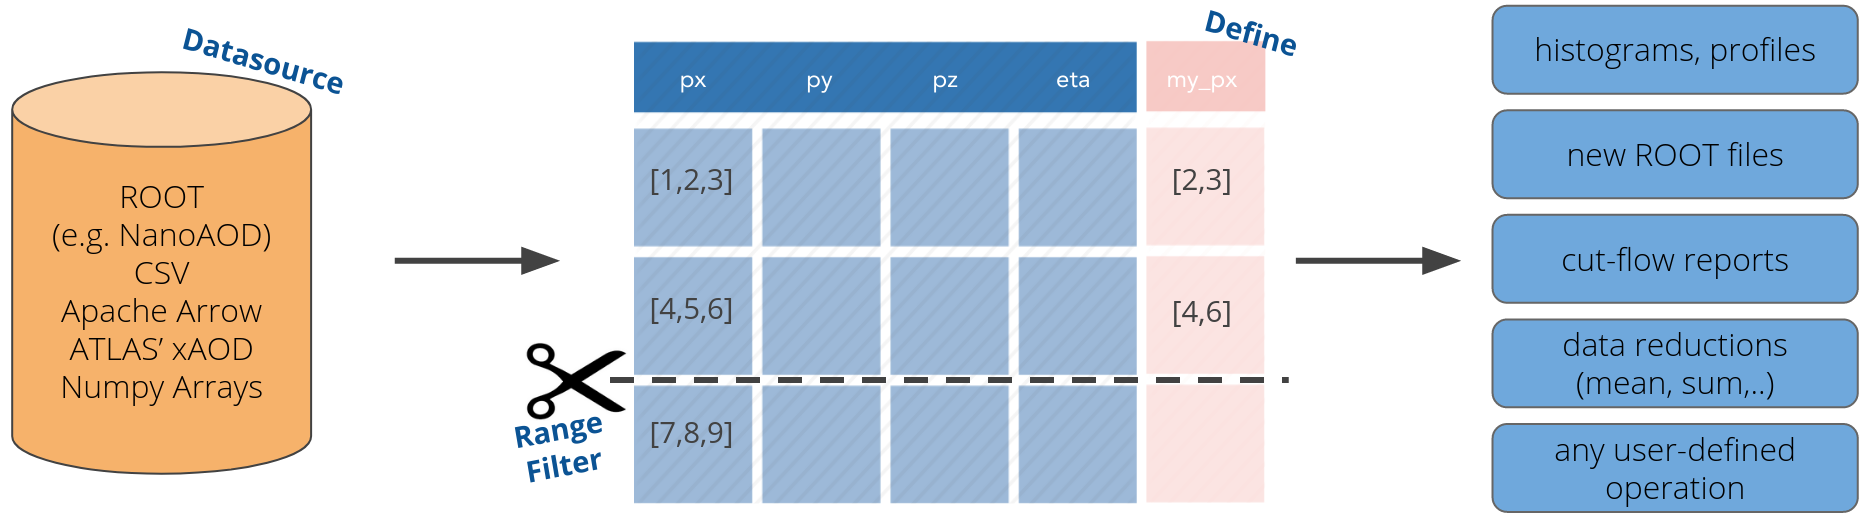


Source and credit: https://github.com/root-project/student-course

In [1]:
import ROOT
# checking the root version
print(f"ROOT Version:{ROOT.__version__}")

ROOT Version:6.32.06


In [2]:
# Enable Mulithreading:
#ROOT.EnableImplicitMT()

In [3]:
# open the root file 
treeName = 'Mytree'
file = 'analysis_ntuple.root'
df = ROOT.RDataFrame(treeName, file)

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3001] Required argument not present



In [4]:
#  Get  the column names in the dataset
print(f"column names in the dataset {df.GetColumnNames()}")
print(f"Number of times event loop Ran {df.GetNRuns()}")

column names in the dataset { "particle_charge", "particle_eta", "particle_mass", "particle_px", "particle_py" }
Number of times event loop Ran 0


Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3001] Required argument not present



In [5]:
%%html
<style>
  th { font-size: 30px }
  td { font-size: 30px }
</style>



# Operations Categories in RDataFrame
1. **Transformations**: manipulate the dataset, return a modified RDataFrame for further processing.

| Transformation    | Description                                                |
|-------------------|------------------------------------------------------------|
| Alias()           | Introduce an alias for a particular column name.           |
| Define()          | Creates  a new column in the dataset.                      |
| Filter()          | Filter rows based on user-defined conditions.              |



2. **Actions**: aggregate (parts of) the dataset into a result.

| Action                        | Description                                                                          |
|------------------------------------|--------------------------------------------------------------------------------------|
| Count()                            | Return the number of events processed.                                               |
| Display()                          | Provides a printable object representing the dataset contents.                       |
| Graph()                            | Fills a TGraph  with the two columns provided.                                       |
| Histo1D(), Histo2D(), Histo3D()    | Fill a one-, two-, three-dimensional histogram with the processed column values.     |
| Max(), Min()                       | Return the maximum(minimum) of processed column values.                              |
| Snapshot()        | Writes processed data-set to a new TTree.              |
| ...                                | ...  


3. **Queries**: these methods  query information about your dataset and the RDataFrame status.

| Operation           | Description                                                                              |
|---------------------|------------------------------------------------------------------------------------------|
| GetColumnNames()    | Get the names of all the available columns of the dataset.                               |
| GetColumnType()     | Return the type of a given column as a string.                                           |
| SaveGraph()         | Export the computation graph of an RDataFrame in graphviz format for easy inspection.     |
| ...                 | ...                                                                                      |

# Defining a column based on custom expression: lazy Transformation
Use ````Define````


In [6]:
# define the pT(transverse momentum) of the particle 
df = df.Define("particle_pT", "sqrt(particle_px*particle_px+particle_py*particle_py)")
print(f"column names in the dataset {df.GetColumnNames()}")
print(f"Number of times event loop Ran {df.GetNRuns()}")

column names in the dataset { "particle_charge", "particle_eta", "particle_mass", "particle_pT", "particle_px", "particle_py" }
Number of times event loop Ran 0


# Filtering the events : Lazy transfromation

Use `Filter`to filter the events with a custom expression


In [7]:
# Let select the events with pt> 50 GeV and eta < 0.8
df1 = df.Filter("particle_pT > 50.", "pT cut")
df1 = df1.Filter("fabs(particle_eta) < 0.8", "eta cut")

# in one line
# df1 = df.Filter("particle_pT > 50.").Filter("fabs(particle_eta) < 0.8")

# Note: so far no event loop has been run
print(f"Number of times event loop Ran {df.GetNRuns()}")


Number of times event loop Ran 0


# Book the histograms : Lazy Action

In [8]:
# plot the pT distribution before and after the cut

# hist_pT_before = df.Histo1D("particle_pT")
# hist_pT_after = df1.Histo1D("particle_pT")

# with the binning 
hist_pT_before = df.Histo1D(("pT_before", "pT_before",40,0,200),"particle_pT")
hist_pT_after = df1.Histo1D(("pT_after", "pT_after",40,0,200),"particle_pT")


print(f"Number of times event loop Ran {df.GetNRuns()}")

Number of times event loop Ran 0


# Cuttflow Report : Trigger the event loop


Number of times event loop Ran 1


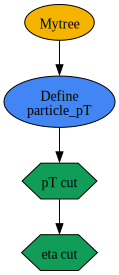

pT cut    : pass=8331       all=10000      -- eff=83.31 % cumulative eff=83.31 %
eta cut   : pass=2707       all=8331       -- eff=32.49 % cumulative eff=27.07 %


In [9]:
report = df1.Report()
report.Print()
print(f"Number of times event loop Ran {df1.GetNRuns()}")
ROOT.RDF.SaveGraph(df1,"DAG.dot")
from graphviz import Source
Source.from_file("DAG.dot")

# Plotting the histograms: Trigger event loop

In [10]:
%jsroot on 
canvas = ROOT.TCanvas()
legend = ROOT.TLegend()
hist_pT_before.SetLineColor(ROOT.kRed)
hist_pT_after.SetLineColor(ROOT.kBlue)
hist_pT_after.Draw() # trigger the event loop
hist_pT_before.Draw("SAME")
hist_pT_after.GetYaxis().SetRangeUser(0,1000)
hist_pT_after.GetXaxis().SetTitle("p_{T} (GeV)")
hist_pT_after.GetYaxis().SetTitle("Events")
canvas.Draw()

print(f"Number of times event loop Ran {df.GetNRuns()}")

Number of times event loop Ran 1


# Storing the histograms into a root file

In [11]:
# write the histogram in a root file
file_out = ROOT.TFile("output.root","RECREATE")
file_out.cd()
hist_pT_after.Write()
hist_pT_before.Write()
print(f"Number of times event loop Ran {df.GetNRuns()}")
# check the content of root file 
print(file_out.ls())
file_out.Close()

Number of times event loop Ran 1
None
TFile**		output.root	
 TFile*		output.root	
  KEY: TH1D	pT_after;1	pT_after
  KEY: TH1D	pT_before;1	pT_before


# Inspecting the dataframe
Use ```Display()``` to see the dataframe in a columnar format


Triggers the event loop, Not a lazy query!

In [12]:
# looking at the file in a columnar format
# open the root file 
treeName = 'Mytree'
file = 'analysis_ntuple.root'
dfprime = ROOT.RDataFrame(treeName, file)
dfprime.Display().Print() # triggers the event loop
print(f"Number of times event loop Ran {df.GetNRuns()}")
# Note: wont work on multithread

Number of times event loop Ran 1
+-----+-----------------+--------------+---------------+-------------+-------------+
| Row | particle_charge | particle_eta | particle_mass | particle_px | particle_py | 
+-----+-----------------+--------------+---------------+-------------+-------------+
| 0   | 1               | 2.162787     | 0.000511      | 80.168912   | 45.325287   | 
+-----+-----------------+--------------+---------------+-------------+-------------+
| 1   | 1               | -2.038307    | 0.105000      | 80.057569   | 34.165339   | 
+-----+-----------------+--------------+---------------+-------------+-------------+
| 2   | 1               | 0.194084     | 0.000000      | -20.263972  | 72.008009   | 
+-----+-----------------+--------------+---------------+-------------+-------------+
| 3   | -1              | -1.477739    | 0.105000      | 61.113170   | 21.052559   | 
+-----+-----------------+--------------+---------------+-------------+-------------+
| 4   | 1               | 0

# Storing into a root file
Use ```Snapshot``` to store the new dataframe into another root file

Not a Lazy Action!


In [13]:
 dfprime = dfprime.Define("particle_pT", "sqrt(particle_px*particle_px+particle_py*particle_py)").Filter("particle_pT > 50.").Filter("fabs(particle_eta) < 0.8")

dfprime.Snapshot('Mytree',"calculated_analysis_ntuple.root", df.GetColumnNames())
print(f"Number of times event loop Ran {df.GetNRuns()}")


Number of times event loop Ran 1
